## Preprocessing

In [1]:
import os
spark_version = 'spark-3.5.0'
os.environ['SPARK_VERSION']=spark_version

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop3.tgz
!tar xf $SPARK_VERSION-bin-hadoop3.tgz
!pip install -q findspark

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [624 kB]
Hit:5 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:6 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:7 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [1,203 kB]
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:9 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,010 kB]
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Hit:11 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Hit:13 http://

In [4]:
#Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop3"

In [5]:
# Start a SparkSession
import findspark
findspark.init()


In [6]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from pyspark.sql import SparkSession
import time



#  Import and read the diabetes_prediction_dataset.csv.
import pandas as pd
url = "https://raw.githubusercontent.com/taywiljoe/Project-4/main/Resources/diabetes_prediction_dataset.csv"
diabetes_df = pd.read_csv(url)
diabetes_df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [7]:
# Determine the number of unique values in each column.
diabetes_df.nunique()

gender                    3
age                     102
hypertension              2
heart_disease             2
smoking_history           6
bmi                    4247
HbA1c_level              18
blood_glucose_level      18
diabetes                  2
dtype: int64

In [8]:
diabetes_df['diabetes'].value_counts()

0    91500
1     8500
Name: diabetes, dtype: int64

In [9]:
recall

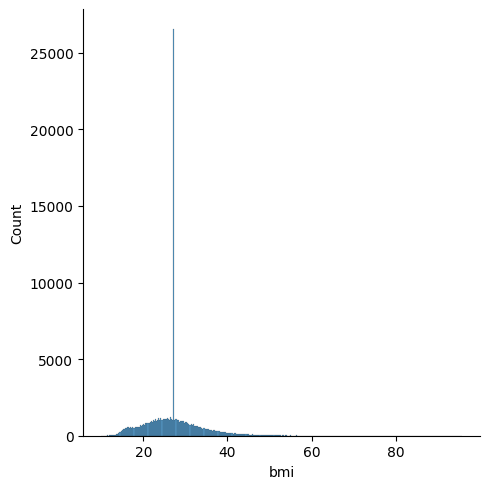

In [10]:
import seaborn as sns
sns.displot(diabetes_df['bmi'])

In [11]:
# Look at bmi value counts for binning
import numpy as np
import math
diabetes_df['bmi'].value_counts()


27.32    25495
23.00      103
27.12      101
27.80      100
24.96      100
         ...  
58.23        1
48.18        1
55.57        1
57.07        1
60.52        1
Name: bmi, Length: 4247, dtype: int64

In [12]:
# load bmi data
dataset = diabetes_df['bmi']
dataset

0        25.19
1        27.32
2        27.32
3        23.45
4        20.14
         ...  
99995    27.32
99996    17.37
99997    27.83
99998    35.42
99999    22.43
Name: bmi, Length: 100000, dtype: float64

In [13]:
#sort the array
bmi_sort=np.sort(dataset)
bmi_sort

array([10.01, 10.01, 10.08, ..., 91.82, 95.22, 95.69])

In [14]:
# create bins
bin0=[]
bin1=[]
bin2=[]
bin3=[]
bin4=[]
bin5=[]

# loop thru array to load bins
for i in range (100000):
     if bmi_sort[i] <= 15 and bmi_sort[i] >= 0:
          bin0.append(bmi_sort[i])
     elif bmi_sort[i] <= 23 and bmi_sort[i] > 15:
          bin1.append(bmi_sort[i])
     elif bmi_sort[i] <= 29 and bmi_sort[i] > 23:
          bin2.append(bmi_sort[i])
     elif bmi_sort[i] <= 33 and bmi_sort[i] > 29:
          bin3.append(bmi_sort[i])
     elif bmi_sort[i] <= 37 and bmi_sort[i] > 33:
          bin4.append(bmi_sort[i])
     elif bmi_sort[i] > 37:
          bin5.append(bmi_sort[i])

# view bin lengths
len(bin0),len(bin1),len(bin2),len(bin3),len(bin4),len(bin5)


(1509, 20984, 50404, 12314, 7047, 7742)

In [16]:
# Choose a cutoff value and create a list of bmi values to be replaced
# use the variable name `bin_types_to_replace`
# Replace bmi values < 14 and > 37 in dataframe
bmi_values_to_replace = bin0

for app in bmi_values_to_replace:
     diabetes_df['bmi'] = diabetes_df['bmi'].replace(app,15.00)

bmi_values_to_replace = bin5

for app in bmi_values_to_replace:
     diabetes_df['bmi'] = diabetes_df['bmi'].replace(app,37.00)

# Check to make sure binning was successful
diabetes_df['bmi'].value_counts()


27.32    25495
37.00     7770
15.00     1509
23.00      103
27.12      101
         ...  
34.62        3
36.48        3
35.76        3
24.49        2
35.16        2
Name: bmi, Length: 2201, dtype: int64

In [17]:
# Convert categorical data to numeric with `pd.get_dummies`
y = diabetes_df['diabetes']
X = diabetes_df.drop(columns='diabetes')
X = pd.get_dummies(X)
X.head()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,gender_Female,gender_Male,gender_Other,smoking_history_No Info,smoking_history_current,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current
0,80.0,0,1,25.19,6.6,140,1,0,0,0,0,0,0,1,0
1,54.0,0,0,27.32,6.6,80,1,0,0,1,0,0,0,0,0
2,28.0,0,0,27.32,5.7,158,0,1,0,0,0,0,0,1,0
3,36.0,0,0,23.45,5.0,155,1,0,0,0,1,0,0,0,0
4,76.0,1,1,20.14,4.8,155,0,1,0,0,1,0,0,0,0


In [18]:
# Import the RandomOverSampler module from imbalanced-learn
from collections import Counter
from imblearn.over_sampling import RandomOverSampler

# Instantiate the random oversampler model
# # Assign a random_state parameter of 1 to the model
ros = RandomOverSampler(random_state=1)

# Fit the original training data to the random_oversampler model
X_res, y_res = ros.fit_resample(X, y)
# Count the distinct values of the resampled labels data
print('Resampled dataset shape %s' % Counter(y_res))


Resampled dataset shape Counter({0: 91500, 1: 91500})


In [19]:
# Split our preprocessed data into our features and target arrays
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, random_state=1)
X_train.shape

# Split the preprocessed data into a training and testing dataset
#  YOUR CODE GOES HERE

(137250, 15)

In [20]:
X_test.shape


(45750, 15)

In [21]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
X_train_scaled

array([[-1.79168244, -0.42468913, -0.31414261, ..., -0.39535497,
        -0.76607461, -0.2801949 ],
       [ 1.36876559, -0.42468913,  3.18326762, ..., -0.39535497,
        -0.76607461, -0.2801949 ],
       [-0.44384431,  2.3546635 , -0.31414261, ..., -0.39535497,
         1.30535588, -0.2801949 ],
       ...,
       [-0.6762302 , -0.42468913, -0.31414261, ..., -0.39535497,
         1.30535588, -0.2801949 ],
       [ 1.36876559,  2.3546635 , -0.31414261, ...,  2.52937254,
        -0.76607461, -0.2801949 ],
       [ 1.22933405, -0.42468913, -0.31414261, ..., -0.39535497,
        -0.76607461, -0.2801949 ]])

In [22]:
X_test_scaled

array([[ 0.06740463, -0.42468913,  3.18326762, ..., -0.39535497,
        -0.76607461, -0.2801949 ],
       [ 0.16035899, -0.42468913, -0.31414261, ..., -0.39535497,
        -0.76607461, -0.2801949 ],
       [-1.32691067, -0.42468913, -0.31414261, ..., -0.39535497,
         1.30535588, -0.2801949 ],
       ...,
       [ 1.22933405, -0.42468913, -0.31414261, ..., -0.39535497,
         1.30535588, -0.2801949 ],
       [-0.53679867, -0.42468913, -0.31414261, ..., -0.39535497,
        -0.76607461,  3.56894433],
       [-1.83815962, -0.42468913, -0.31414261, ..., -0.39535497,
        -0.76607461, -0.2801949 ]])

In [23]:
#Setupe input to model
dim_set = X_test.shape[1]
hidden_layer1 = 80
hidden_layer2 = 30
hidden_layer3 = 4

## Compile, Train and Evaluate the Model

In [24]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
nn_model = tf.keras.models.Sequential()

# First hidden layer
nn_model.add(tf.keras.layers.Dense(units=hidden_layer1, activation="relu", input_dim=dim_set))

# Second hidden layer
nn_model.add(tf.keras.layers.Dense(units=hidden_layer2, activation="relu"))

# Third hidden layer
nn_model.add(tf.keras.layers.Dense(units=hidden_layer3, activation="relu"))

# Output layer
nn_model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                1280      
                                                                 
 dense_1 (Dense)             (None, 30)                2430      
                                                                 
 dense_2 (Dense)             (None, 4)                 124       
                                                                 
 dense_3 (Dense)             (None, 1)                 5         
                                                                 
Total params: 3839 (15.00 KB)
Trainable params: 3839 (15.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [25]:
# Compile the model
nn_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [26]:
# Train the model
fit_model = nn_model.fit(X_train_scaled, y_train, epochs=50)

Epoch 1/50
4290/4290 [==============================] - 11s 2ms/step - loss: 0.2440 - accuracy: 0.8867
Epoch 2/50
4290/4290 [==============================] - 12s 3ms/step - loss: 0.1905 - accuracy: 0.9065
Epoch 3/50
4290/4290 [==============================] - 11s 3ms/step - loss: 0.1841 - accuracy: 0.9089
Epoch 4/50
4290/4290 [==============================] - 12s 3ms/step - loss: 0.1818 - accuracy: 0.9103
Epoch 5/50
4290/4290 [==============================] - 12s 3ms/step - loss: 0.1798 - accuracy: 0.9118
Epoch 6/50
4290/4290 [==============================] - 9s 2ms/step - loss: 0.1782 - accuracy: 0.9120
Epoch 7/50
4290/4290 [==============================] - 12s 3ms/step - loss: 0.1761 - accuracy: 0.9136
Epoch 8/50
4290/4290 [==============================] - 10s 2ms/step - loss: 0.1747 - accuracy: 0.9138
Epoch 9/50
4290/4290 [==============================] - 11s 3ms/step - loss: 0.1737 - accuracy: 0.9139
Epoch 10/50
4290/4290 [==============================] - 11s 2ms/step - lo

In [27]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn_model.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

1430/1430 - 3s - loss: 0.1524 - accuracy: 0.9264 - 3s/epoch - 2ms/step
Loss: 0.15241362154483795, Accuracy: 0.9263606667518616


In [28]:
# Export our model to HDF5 file
# print("The model is saved to HDF5 format")
nn_model.save('/content/drive/MyDrive/Diabetes_3layers_Optimization.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
